In [18]:
# DEV SCRIPT - DO NOT USE
import gen_funcs as gf
import ranked_funcs as rf
import clump_funcs as cf
import os
import numpy as np

In [2]:
# Select desired figures
print("Running setup operations", flush=True)
selected_figs = ["old"]
# selected_figs = ["Fig2_Fig4", "Fig6", "Fig7", "Fig8"]

Running setup operations


In [3]:
# Load paths
path_paths = "paths.json"
dict_paths = gf.load_paths_all(path_paths)

(gen_funcs.load_paths_all)
	Reading paths


In [4]:
# Load data
path_data = dict_paths["path_data"]
paths_psliceout = gf.load_paths_psliceout(path_data, selected_figs)
data_all = gf.iteratively_load_data(paths_psliceout)

(gen_funcs.iteratively_load_data)
	Loading data
		Loading file ./data/old/psliceout1.dat


In [5]:
# Rank particles
path_ranked = dict_paths["path_ranked"]
n_neighbors = 100
fout_ranked = gf.iteratively_rank_neighbors(data_all, paths_psliceout, path_ranked, n_neighbors)

(gen_funcs.iteratively_rank_neighbors)
	Ranking particles
		Ranking file ./data/old/psliceout1.dat
(ranked_funcs.rank_neighbors)
	Checking if ranked file exists
		Ranked file ./output/ranked/ranked_100neigh_psliceout1.dat already exists. Skipping.


In [31]:
# Use ranked data to get COM coordinates
print("Using ranked data to get COM coordinates", flush=True)

# Calculate Roche density as threshold
G = 1
Omega_K = 1
H_g = np.pi
threshold_rho = cf.calculate_density_Roche(G, Omega_K, H_g)

# Get COM coordinates for all ranked particles
data_ranked = {}
coords_com_ranked = {}
for key in fout_ranked:
    for fin_ranked in fout_ranked[key]:
        try:
            data_ranked[fin_ranked]
        except KeyError:
            _data_ranked, _coords_com_ranked = rf.get_com_coords(fin_ranked, n_neighbors, threshold_rho)
            data_ranked[fin_ranked] = _data_ranked
            coords_com_ranked[fin_ranked] = _coords_com_ranked

Using ranked data to get COM coordinates


(ranked_funcs.get_com_coords)


In [32]:
coords_com_ranked['./output/ranked/ranked_100neigh_psliceout1.dat']

array([[ 1.09048e+01, -1.53215e+01, -5.17648e-02,  4.65093e-07],
       [ 1.09048e+01, -1.53215e+01, -5.17648e-02,  4.69049e-07],
       [ 1.09048e+01, -1.53215e+01, -5.17648e-02,  4.70104e-07],
       ...,
       [ 2.54242e+01,  4.74766e+01, -4.06339e-02,  2.88723e-01],
       [-2.34735e+00,  4.01430e+01, -8.26641e-02,  2.88723e-01],
       [-1.48748e+01, -4.88313e+00, -1.22432e-01,  2.88723e-01]])

Calculating the frequency of each radius


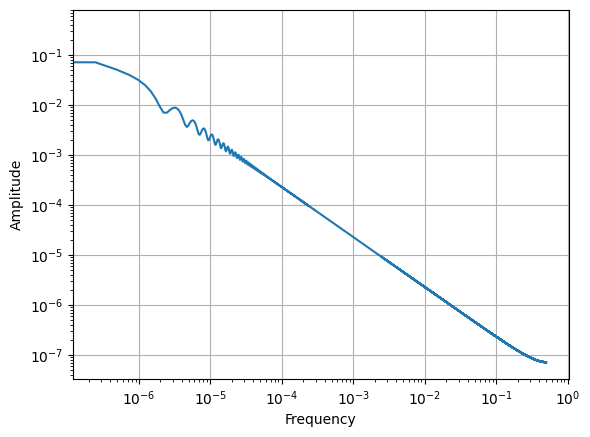

In [40]:
# Fourier frequency analysis on coords_com_ranked['radius']
# Calculate the frequency of each radius
print("Calculating the frequency of each radius", flush=True)
radius = coords_com_ranked['./output/ranked/ranked_100neigh_psliceout1.dat'][:,-1]
from scipy.fftpack import fft
N = len(radius)
T = 1
yf = fft(radius)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
import matplotlib.pyplot as plt
plt.loglog(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

In [38]:
max(radius)

0.288723